In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
RANDOM_SEED=25

In [2]:
df = pd.read_csv('data/filmdeathcounts.csv', sep=',')

In [3]:
df.head()

,Film,Year,Body_Count,MPAA_Rating,Genre,Director,Length_Minutes,IMDB_Rating
0,24 Hour Party People,2002,7,R,Biography|Comedy|Drama|Music,Michael Winterbottom,117,7.3
1,28 Days Later,2002,53,R,Horror|Sci-Fi|Thriller,Danny Boyle,113,7.6
2,28 Weeks Later,2007,212,R,Horror|Sci-Fi|Thriller,Juan Carlos Fresnadillo,100,7.0
3,30 Days of Night,2007,67,R,Horror|Thriller,David Slade,113,6.6
4,300,2007,600,R,Action|Fantasy|History|War,Zack Snyder,117,7.7


In [4]:
# Homework 2, I
# Choost 3-6 features, explain
# Apply k-means at k=5, k=9
# In both cases take 10 or more random inits, choose the best over the K-means criterion
# Homework 2, II
# Take one partition
# Compare one of the features between two clusters using bootstrap
# Take a feature, find 95% confidence interval for grand mean using bootstrap
# Take a cluster, compare the grand mean with the within-cluster mean for the feature by using bootstrap
# Note: each application of bootstrap sohuld be done inboth pivotal and non-pivotal versions

In [7]:
# We select these features for clustering, as they are the only quantitative features
quant_features = ['Body_Count', 'Length_Minutes', 'Year']

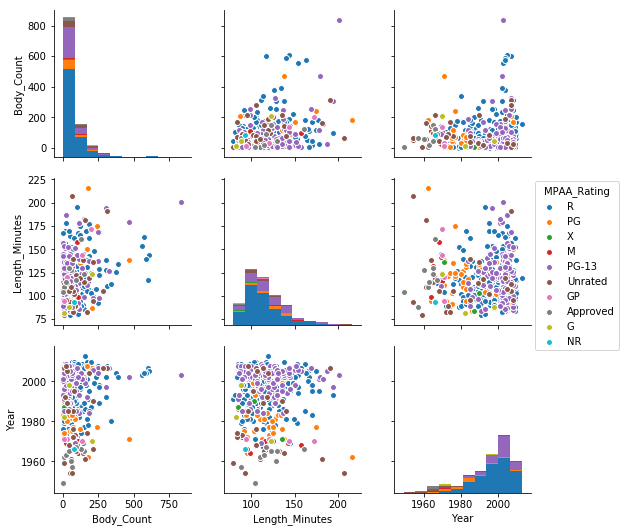

In [6]:
# Our data contains MPAA_Rating, which is a categorical feature. We do not use it in clustering, 
# because clusters might follow the categorical feature when it's used together with quantitative features.
# Its interesting to see how ratings divide movies in categories.
# Evidently the amount of R movies is much larger than all others, and they contain most of the Body_Count, and they mostly recent.
sns.pairplot(df, hue='MPAA_Rating', vars=quant_features)

In [11]:
# Before applying KNN we will center our data by mean and normalize it by range.
def normalize(vec):
    # center by mean, normalize by range
    return (vec - vec.mean())/(vec.max() - vec.min())

In [12]:
# K-means
features = quant_features
task_df = pd.DataFrame(df[features])

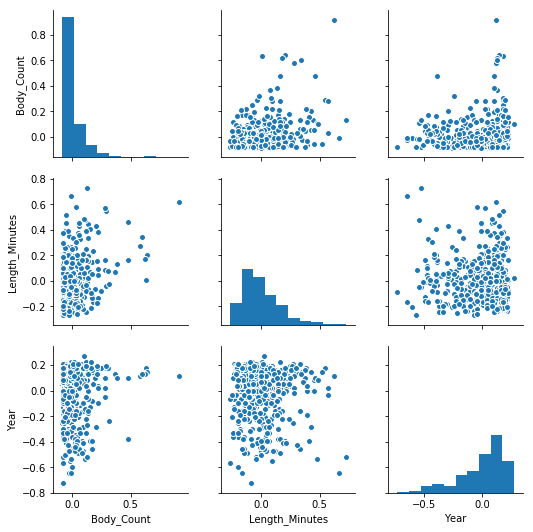

In [14]:
task_df = normalize(task_df)
sns.pairplot(task_df, vars=quant_features)
# Data is normalized

Sum of squared distances from points to cluster centers, k=5: 13.612553363194287


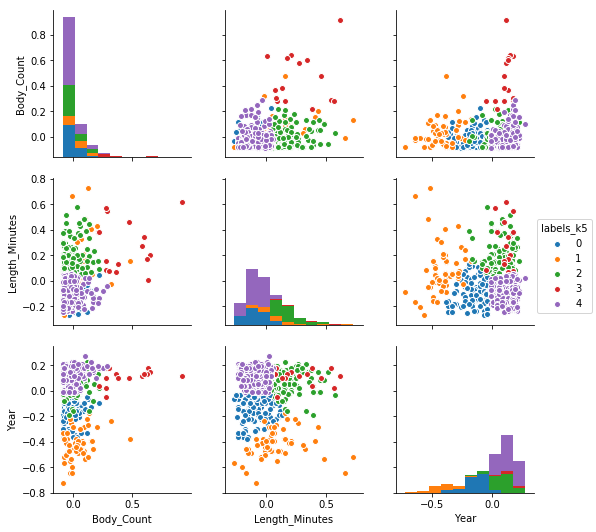

In [16]:
# Kmeans, k = 5
# Random initialization, 10 random inits, choose best by kmeans criterion
# Divides data into interpretable categories easily and very descriptive.
# Interesting that Kmeans clustering obtained doesn't match to MPAA_Rating directly.
kmeans_k5 = KMeans(n_clusters=5, init='random', n_init=10, random_state=RANDOM_SEED)
kmeans_k5.fit(task_df)
task_df['labels_k5'] = pd.Series(kmeans_k5.predict(task_df))
print('Sum of squared distances from points to cluster centers, k=5:', kmeans_k5.inertia_)
sns.pairplot(task_df, hue='labels_k5', vars=quant_features)

Sum of squared distances from points to cluster centers, k=9: 35.04362994469997


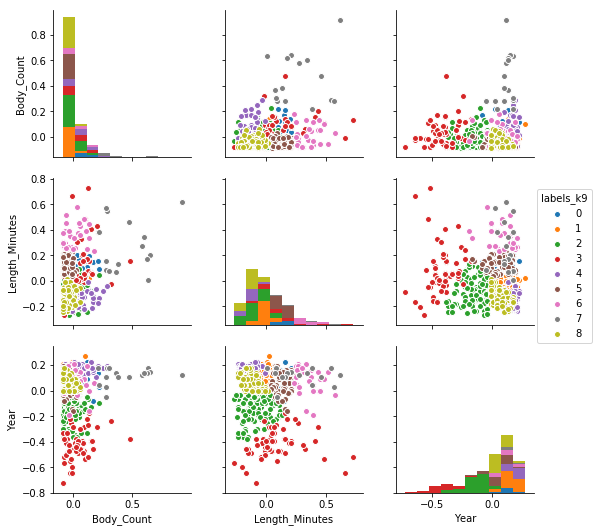

In [18]:
# Kmeans, k = 9
# At 9 clusters we get a lot of smaller clusters.
# It seems there appeared separate clusters for Body_Count outliers (e.g. cluster 2, green), Length otliers (cluster 3, red)
# However the main body of movies is divided between many clusters that overlap a lot. 
# Seems like 9 clusters are a bit too many for that dataset as cluster boundaries are not clear.
kmeans = KMeans(n_clusters=9, init='random', n_init=10, random_state=RANDOM_SEED) # kmeans, random initialization, 10 random inits, choose best by kmeans criterion
kmeans.fit(task_df)
task_df['labels_k9'] = pd.Series(kmeans.predict(task_df))
print('Sum of squared distances from points to cluster centers, k=9:', kmeans.inertia_)
sns.pairplot(task_df, hue='labels_k9', vars=quant_features)

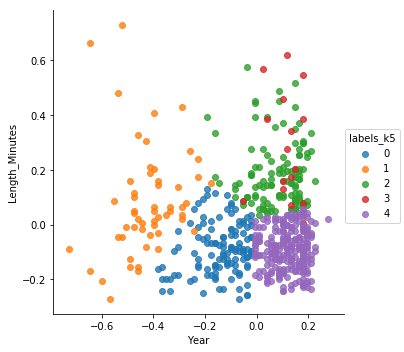

In [20]:
# Let's inspect a partition of Kmeans, k=5, closely.
sns.lmplot(x="Year", y="Length_Minutes", fit_reg=False, data=task_df, hue='labels_k5')

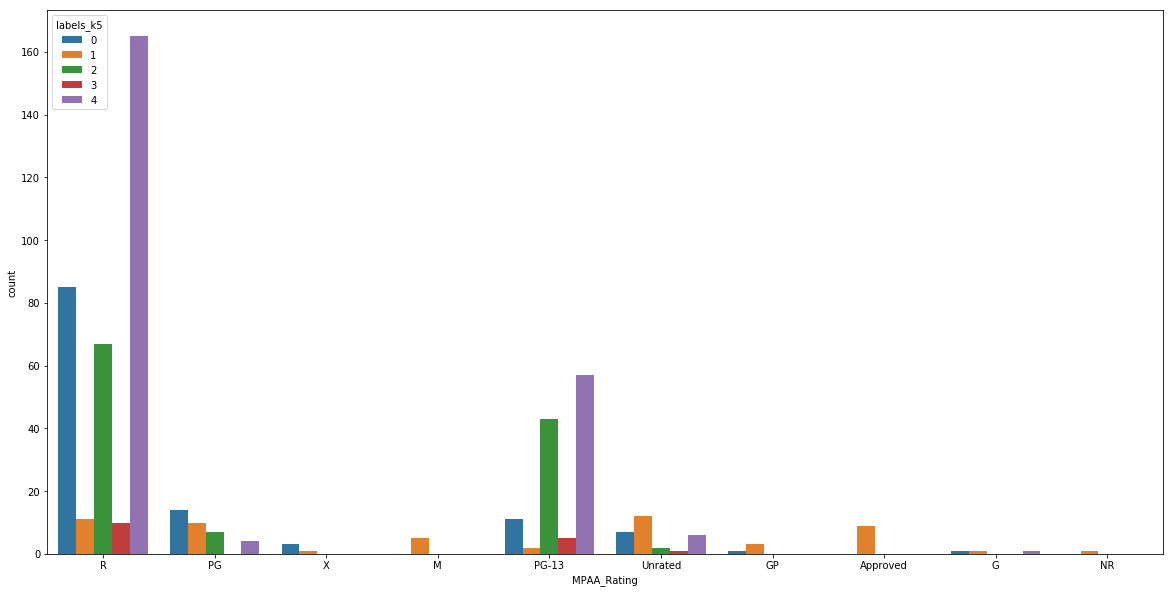

In [26]:
df['labels_k5'] = task_df['labels_k5']
fig = plt.figure(figsize=(20,10))
sns.countplot(x='MPAA_Rating', hue='labels_k5', data=df)
# Let's see how different rating movies are distributed along clusters
# The plot shows the amount of movies of each rating in each cluster.
# For example we see that 165 R movies are in cluster 4.
# Seems like clusters 0, 2, 4 aggregated most of the movies, mostly with R and PG-13 ratings.
# Perhaps inspecting individual features we can understand why.

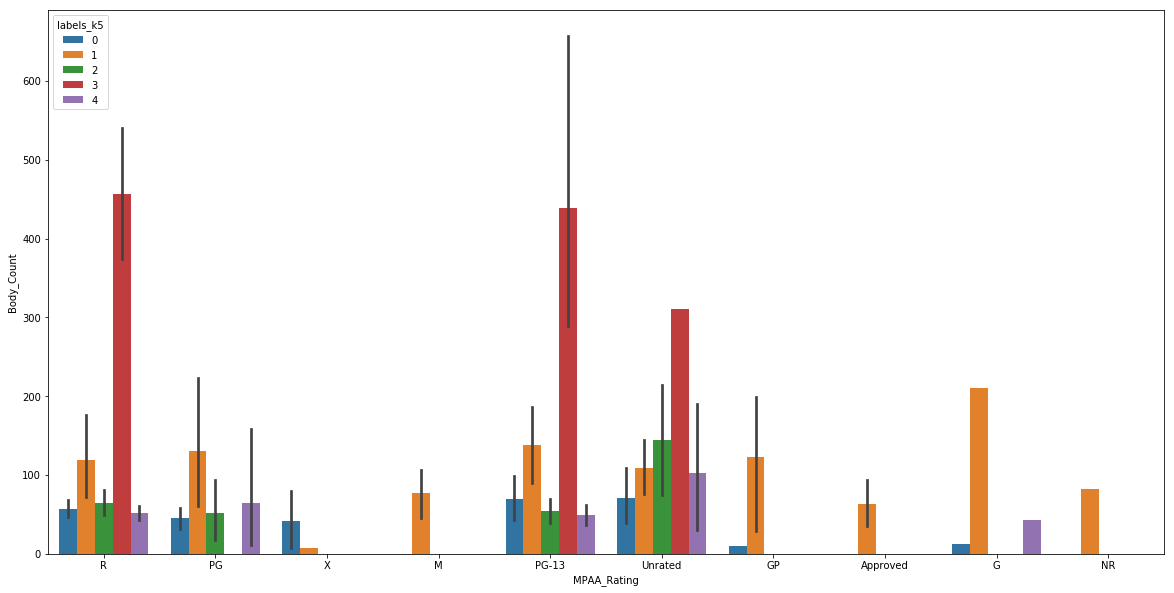

In [30]:
fig = plt.figure(figsize=(20,10))
sns.barplot(x='MPAA_Rating', y='Body_Count', hue='labels_k5', data=df)
# This plot is a mix of bar plot and boxplot. 
# The height of each bar shows the average body count of movies of a certain rating in a cluster.
# The vertical black bar represents the spread - the highest point shows the maximum, the lowest point shows the minimum.
# It's clear that cluster 3 contains the movies with the highest body count.
# It contains the PG-13 movie with the highest body count of all times: Lord of the Rings: Return of the King.
# Which has a body count of 836.
# Good movie, by the way.

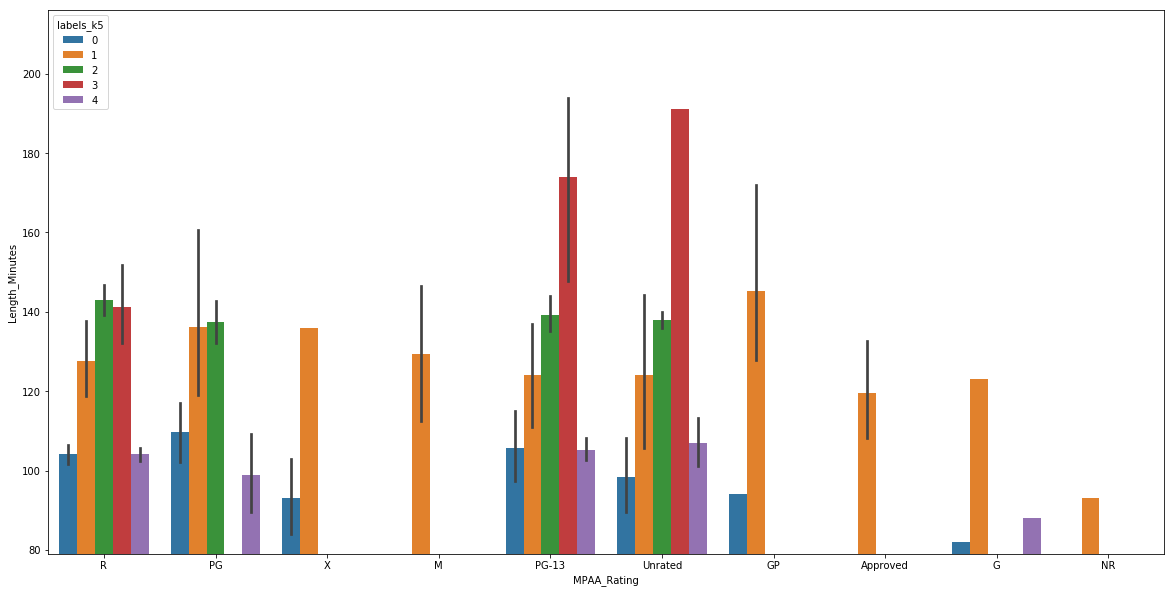

In [32]:
fig = plt.figure(figsize=(20,10))
plt.ylim(bottom=df.Length_Minutes.min(), top = df.Length_Minutes.max())
sns.barplot(x='MPAA_Rating', y='Length_Minutes', hue='labels_k5', data=df)
# The height of each bar shows the average length of movies of a certain rating in a cluster.
# Length is not very discriptive. 
# We can only say that movies in clusters 0 and 1 are on average shorter than other movies.

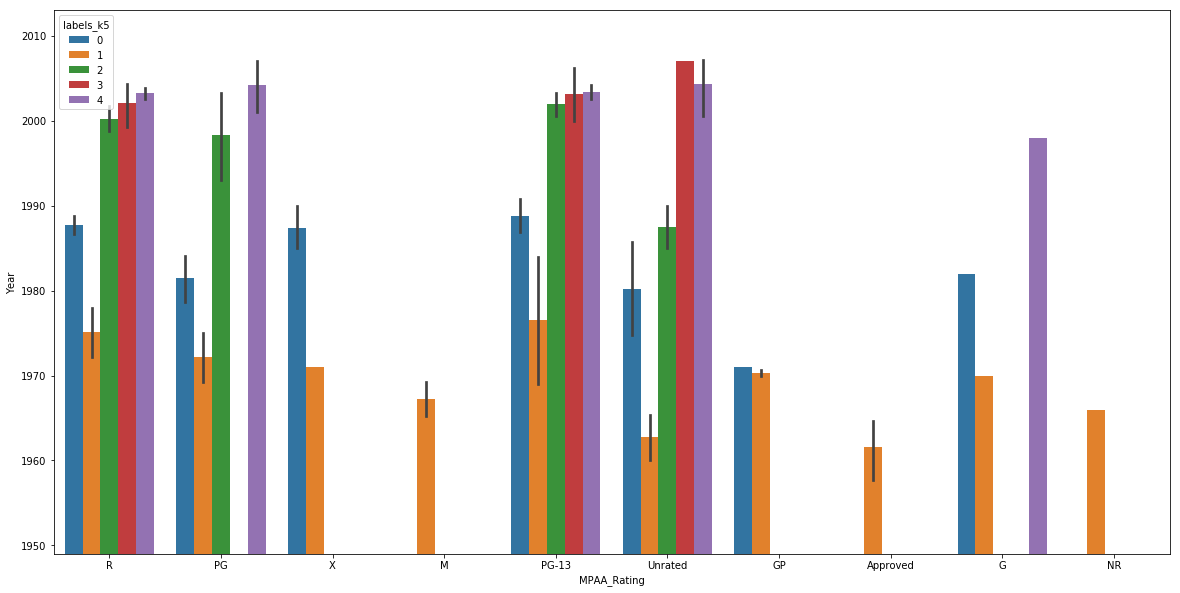

In [34]:
fig = plt.figure(figsize=(20,10))
plt.ylim(bottom=df.Year.min(), top = df.Year.max())
sns.barplot(x='MPAA_Rating', y='Year', hue='labels_k5', data=df)
# The height of each bar shows the average release year of movies of a certain rating in a cluster.
# Cluster 1 contains mostly old, pre-1980 movies. Cluster 0 is about the 90-s.
# Interestingly the highest body count movies, captured by cluster 3, are mostly recent - post-2010.

In [35]:
task_df.labels_k5.value_counts()

4    233
0    122
2    119
1     55
3     16
Name: labels_k5, dtype: int64

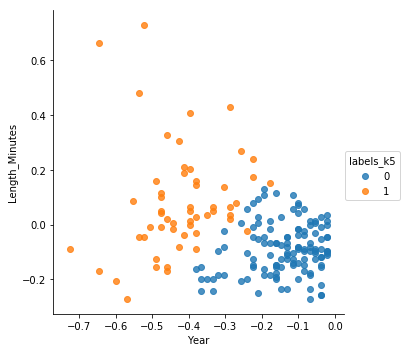

In [46]:
# Let's inspect two clusters closely: cluster 0 and 1. 
# About them we know:
# Cluster 1 contains mostly old, pre-1980 movies. Cluster 0 is about the 90-s.
# Cluster 0 has over 2 times the amount of movies compared to cluster 1. 
# We do not know much about the body count difference between them however.
cluster_0 = df[task_df['labels_k5'] == 0]
cluster_1 = df[task_df['labels_k5'] == 1]
sns.lmplot(x="Year", y="Length_Minutes", fit_reg=False, data=task_df[(task_df['labels_k5'] == 0)|(task_df['labels_k5'] == 1)], hue='labels_k5')

In [47]:
# We will compare their Body_Count, as the most interesting feature.
target_feature = 'Body_Count'

count    122.000000
mean      56.795082
std       47.931414
min        1.000000
25%       20.000000
50%       42.500000
75%       87.250000
max      258.000000
Name: Body_Count, dtype: float64

count     55.000000
mean     105.654545
std       87.318323
min        4.000000
25%       44.500000
50%       91.000000
75%      147.000000
max      471.000000
Name: Body_Count, dtype: float64


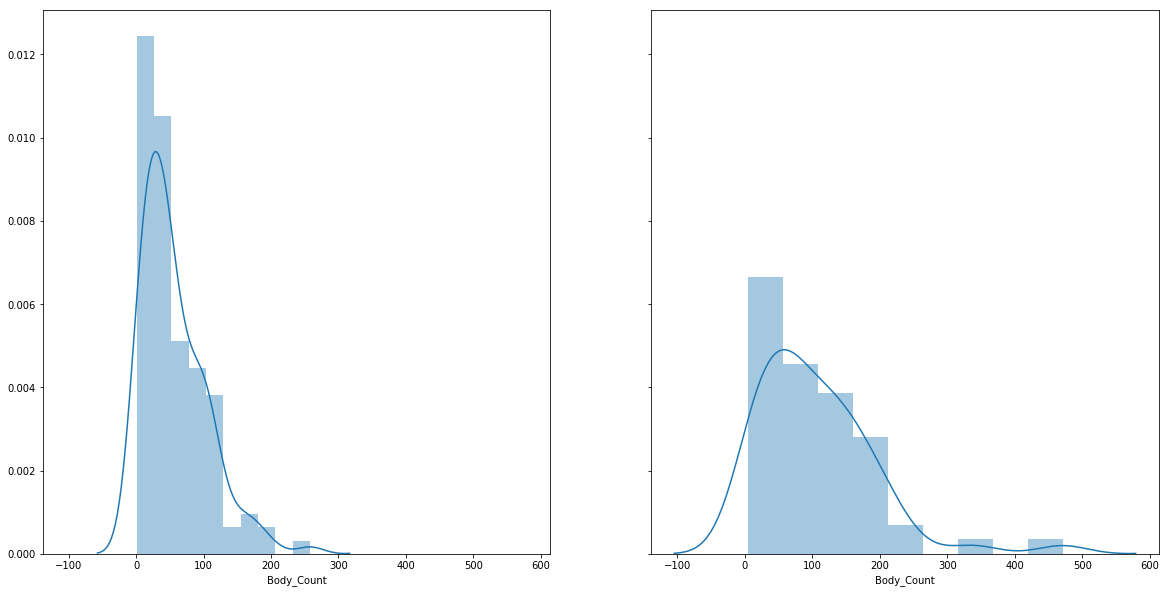

In [48]:
# Histograms tell us their distributions differ, but we do not have enough samples to be sure.
print(cluster_0[target_feature].describe())
print()
print(cluster_1[target_feature].describe())
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(1, 2, sharex=True, sharey=True)

sns.distplot(cluster_0.Body_Count, ax=axes[0])
sns.distplot(cluster_1.Body_Count, ax=axes[1])

In [49]:
def bootstrap_sample(vec, size):
    return np.random.choice(vec, size=(vec.shape[0], size), replace=True)

def bootstrap_means(srs, sample_amount=5000):
    samples_ix = bootstrap_sample(srs.index, size=sample_amount).T
    means = np.array([srs.loc[sample].mean() for sample in samples_ix])
    return means

95% confidence intervals
For cluster 0
pivotal 56.83192786885246 +- [48.382188750197514, 65.2816669875074]
non pivotal 56.83192786885246 +- [48.90163934426229, 65.55758196721311]

For cluster 1
pivotal 105.62885818181817 +- [82.64639614766133, 128.611320215975]
non pivotal 105.62885818181817 +- [84.01772727272727, 130.05999999999992]


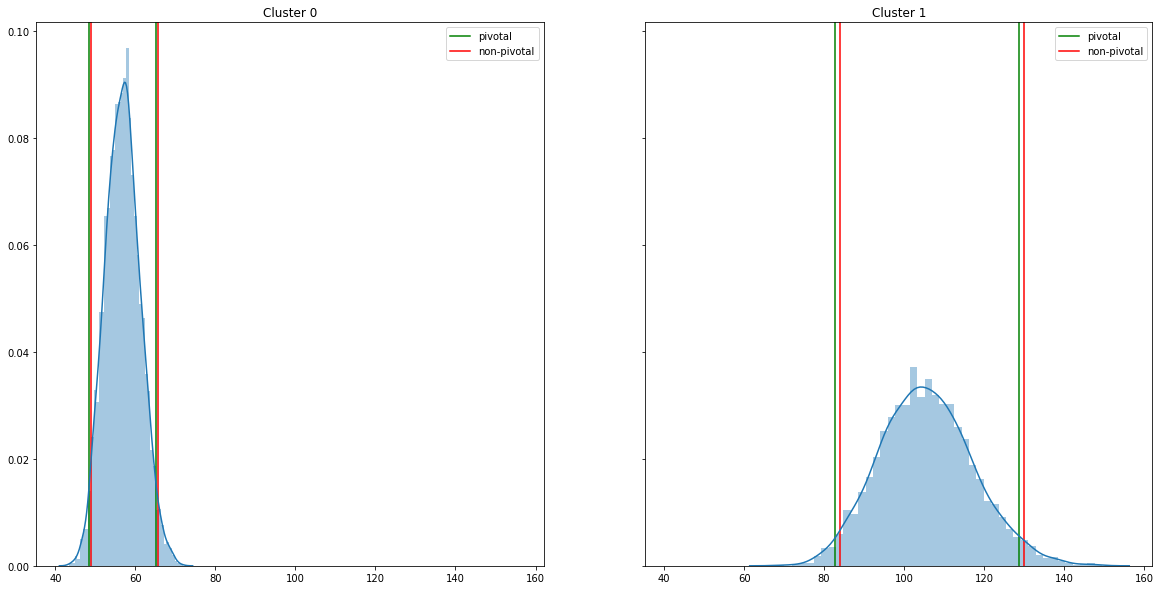

In [52]:
b_means_cluster_0 = bootstrap_means(cluster_0.Body_Count)
b_means_cluster_1 = bootstrap_means(cluster_1.Body_Count)

def confidence_interval_pivotal(vec):
    mean = vec.mean()
    std = vec.std()
    return [mean-1.96*std, mean+1.96*std]

def confidence_interval_non_pivotal(vec, alpha):
    left = np.percentile(vec, (100-alpha)/2)
    right = np.percentile(vec, alpha+(100-alpha)/2)
    #print(len(vec), int((alpha+(100-alpha)/2)*len(vec)))
    #print(np.sort(vec)[int((alpha+(100-alpha)/2)*len(vec))])
    return [left, right]

def distplot_with_conf_intervals(vec, ax=None):
    if not ax:
        ax = plt.gca()
    for x in confidence_interval_pivotal(vec):
        line = ax.axvline(x=x, color='g')
    line.set_label('pivotal')
    for x in confidence_interval_non_pivotal(vec, 95):
        line = ax.axvline(x=x, color='r')
    line.set_label('non-pivotal')
    ax.legend(loc='best')
    return sns.distplot(vec, ax=ax, norm_hist=False)

print('95% confidence intervals')
print('For cluster 0')
print('pivotal', b_means_cluster_0.mean(), '+-', confidence_interval_pivotal(b_means_cluster_0))
print('non pivotal', b_means_cluster_0.mean(), '+-', confidence_interval_non_pivotal(b_means_cluster_0, 95))
print()
print('For cluster 1')
print('pivotal', b_means_cluster_1.mean(), '+-', confidence_interval_pivotal(b_means_cluster_1))
print('non pivotal', b_means_cluster_1.mean(), '+-', confidence_interval_non_pivotal(b_means_cluster_1, 95))

fig = plt.figure(figsize=(20,10))
axes = fig.subplots(1, 2, sharex=True, sharey=True)
axes[0].set_title('Cluster 0')
distplot_with_conf_intervals(b_means_cluster_0, ax=axes[0])
axes[1].set_title('Cluster 1')
distplot_with_conf_intervals(b_means_cluster_1, ax=axes[1])

# Applying bootstrap with 5000 samples
# We obtain that between these clusters the distributions of Body_Count really differ.
# They not only have different means, as evident by confidence intervals, byt also have different bell shapes.
# Interestingly the pivotal and non-pivotal confidence intervals are almost same. 
# We draw the conclusion, that movie body count distribution is approximately Gaussian.

95% confidence intervals
For the grand mean
pivotal 72.15726385321102 +- [64.37419120011303, 79.94033650630901]
non pivotal 72.15726385321102 +- [64.65105504587156, 80.23775229357797]

For cluster 0
pivotal 56.83192786885246 +- [48.382188750197514, 65.2816669875074]
non pivotal 56.83192786885246 +- [48.90163934426229, 65.55758196721311]


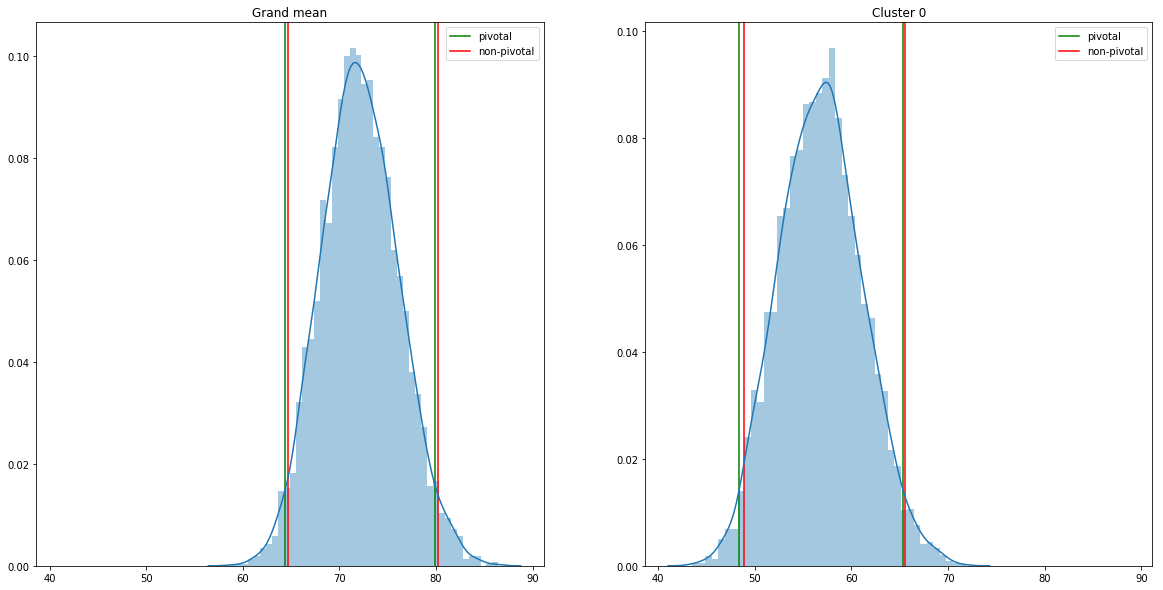

In [54]:
grand_mean_b_samples = bootstrap_means(df.Body_Count)
print('95% confidence intervals')
print('For the grand mean')
print('pivotal', grand_mean_b_samples.mean(), '+-', confidence_interval_pivotal(grand_mean_b_samples))
print('non pivotal', grand_mean_b_samples.mean(), '+-', confidence_interval_non_pivotal(grand_mean_b_samples, 95))
print()
print('For cluster 0')
print('pivotal', b_means_cluster_0.mean(), '+-', confidence_interval_pivotal(b_means_cluster_0))
print('non pivotal', b_means_cluster_0.mean(), '+-', confidence_interval_non_pivotal(b_means_cluster_0, 95))
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(1, 2, sharex=True)
axes[0].set_title('Grand mean')
distplot_with_conf_intervals(grand_mean_b_samples, ax=axes[0])
axes[1].set_title('Cluster 0')
distplot_with_conf_intervals(b_means_cluster_0, ax=axes[1])
# We use bootstrap to compare cluster 0 to the grand mean.
# Interestingly the bell shape of cluster 0 body count resembles the grand mean bell shape closely.